In [1]:
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
import datetime
#with open('Ethan.json') as json_file:
 #   data = json.load(json_file)
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import pydotplus
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


# Cleaning And Defining data

In [2]:
#download the data. usually just change the numbers for a different dataset
#Commence cleaning of data

#big combo can easily be changed for various levels of interest
fwjr = pd.read_parquet("fwjr_0301_0305.parquet")
classads = pd.read_parquet("classAds_0301_0305.parquet")
fwjr['CRAB_Id'] = fwjr['fwjr_id'].str.extract(r'([0-9]+)-[0-9]+') 
fwjr['CRAB_Retry'] = fwjr['fwjr_id'].str.extract(r'[0-9]+-([0-9])+') 
fwjr['Big_Combo'] = fwjr.task+fwjr.fwjr_id
classads['Big_Combo'] = classads.CRAB_Workflow+classads['CRAB_Id']+'-'+classads['CRAB_Retry']

In [3]:

#cleanads and fwjr have dropped the duplicates in Big_Combo
print(len(classads))
print(len(classads.drop_duplicates(subset = 'Big_Combo')))
cleanads = classads.drop_duplicates(subset = 'Big_Combo')
#cleanads = classads[classads.CRAB_Retry == '0']
print(len(cleanads))

print(len(fwjr))
print(len(fwjr.drop_duplicates(subset = 'Big_Combo')))
fwjr = fwjr.drop_duplicates(subset = 'Big_Combo')

1660823
1660823
1660823
1193159
1186990


In [4]:
#cleanads = cleanads[cleanads['CMS_TaskType'].notna()]
#for i in cleanads:
    #cleanads[i] = pd.to_numeric(cleanads[i],errors='ignore',downcast = 'float')

In [5]:

#creates the isboth category which is the target variable

cleanads['isboth'] = np.where(cleanads['Big_Combo'].isin(fwjr['Big_Combo']), 1, 0)
#cleanads = (cleanads.sort_values(by = ['isboth'],ascending = False)).reset_index()
print(len(cleanads[cleanads.isboth == 1]))
print(len(cleanads))
print(len(cleanads[cleanads.isboth == 1])/len(cleanads))
print(len(fwjr))


fwjr['isboth'] = np.where(fwjr['Big_Combo'].isin(classads['Big_Combo']), 1, 0)


1060775
1660823
0.6387044254565357
1186990


In [6]:

#analyzes cleanads to make decision on dates for goodads
dates = []
shared = []
length = []
for i in cleanads.day.unique():
    dates.append(i)
    
dates.sort()
for i in dates:
    shared.append(sum(cleanads[cleanads.day == i]['isboth'])/len(cleanads[cleanads.day == i])*100%100)
    length.append(len(cleanads[cleanads.day == i]))
print(dates)    
print(shared)
print(length)

[1551398400.0, 1551484800.0, 1551571200.0, 1551657600.0, 1551744000.0]
[48.457132586009635, 79.05259795928659, 69.05055148635437, 57.30114550186486, 66.09575643350466]
[289299, 297445, 291485, 376167, 406427]


In [7]:
#analyzes fwjr to make decision on dates for goodfwjr
dates = []
shared = []
length = []
for i in fwjr.day.unique():
    dates.append(i)
    
dates.sort()
for i in dates:
    shared.append(sum(fwjr[fwjr.day == i]['isboth'])/len(fwjr[fwjr.day == i])*100%100)
    length.append(len(fwjr[fwjr.day == i]))
print(dates)    
print(shared)
print(length)

[1551139200, 1551225600, 1551312000, 1551398400, 1551484800, 1551571200, 1551657600, 1551744000, 1551830400]
[0.0, 0.0, 0.0, 87.2662968197383, 97.75227956895424, 93.39085281312646, 92.66508900092603, 95.56938889605642, 13.841377869317334]
[1, 6, 65, 142221, 229210, 226474, 242975, 279036, 67002]


In [8]:
#Shows the number of unique values by field.  Any field with '0' unique values in the first or third set should be removed

print('Number of Unique Values in Each Field of FWJR:\n')
print(fwjr[fwjr.day.isin([1551484800, 1551571200, 1551657600, 1551744000])].nunique())
print('')
print('Number of Unique Values in Each Field of Shared:\n')
print(cleanads[cleanads.isboth == 0][cleanads.day.isin([1551484800.0, 1551571200.0, 1551657600.0, 1551744000.0])].nunique())
print('')
print('Number of Unique Values in Each Field of Cleanads:\n')
print(cleanads[cleanads.day.isin([1551484800.0, 1551571200.0, 1551657600.0, 1551744000.0])].nunique())

Number of Unique Values in Each Field of FWJR:

day                  4
d_dataset_id      1566
task              3214
fwjr_id          69195
host                14
files_read         135
CRAB_Id          10000
CRAB_Retry          10
Big_Combo       977695
isboth               2
dtype: int64

Number of Unique Values in Each Field of Shared:



/Users/ethangreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


CMS_TaskType          2
RecordTime       197371
day                   4
d_dataset_id       1209
CRAB_Workflow      2457
CRAB_Id           13221
CRAB_Retry          114
CRAB_UserHN         215
Campaign            215
ErrorType             8
RequestCpus           4
ScheddName           13
WallClockHr       42450
Status                2
Big_Combo        450935
isboth                1
dtype: int64

Number of Unique Values in Each Field of Cleanads:

CMS_TaskType           2
RecordTime        328081
day                    4
d_dataset_id        1722
CRAB_Workflow       3785
CRAB_Id            15105
CRAB_Retry           114
CRAB_UserHN          236
Campaign             236
ErrorType              8
RequestCpus            4
ScheddName            14
WallClockHr        66424
Status                 2
Big_Combo        1371524
isboth                 2
dtype: int64


In [9]:
cleanads.head()

,CMS_TaskType,RecordTime,day,d_dataset_id,CRAB_Workflow,CRAB_Id,CRAB_Retry,CRAB_UserHN,Campaign,ErrorType,RequestCpus,ScheddName,WallClockHr,Status,Big_Combo,isboth
0,None,1551501569000,1.551485e+09,13744859,190201_201214:hnguyen_crab_QCD_Pt_600to800_Tun...,312,4,hnguyen,crab_hnguyen,Success,1,crab3@vocms0107.cern.ch,22.737222222222222,Completed,190201_201214:hnguyen_crab_QCD_Pt_600to800_Tun...,1
1,cmsRun,1551519859000,1.551485e+09,13711372,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,948,3,nmccoll,crab_nmccoll,FileRead,1,crab3@vocms0107.cern.ch,0.5894444444444444,Completed,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,0
2,cmsRun,1551662203000,1.551658e+09,13711372,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,249,4,nmccoll,crab_nmccoll,FileRead,1,crab3@vocms0107.cern.ch,8.303333333333333,Completed,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,0
3,cmsRun,1551687356000,1.551658e+09,13711372,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,275,4,nmccoll,crab_nmccoll,Success,1,crab3@vocms0107.cern.ch,11.368055555555555,Completed,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,1
4,cmsRun,1551642219000,1.551571e+09,13711372,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,241,5,nmccoll,crab_nmccoll,FileRead,1,crab3@vocms0107.cern.ch,13.565555555555555,Completed,190213_043317:nmccoll_crab_TTToHadronic_TuneCP...,0


In [10]:
fwjr.head()

,day,d_dataset_id,task,fwjr_id,host,files_read,CRAB_Id,CRAB_Retry,Big_Combo,isboth
0,1551657600,13518842,190209_130015:biwang_crab_BladeRunnerZH_ZToEE_...,1-0,vocms0121.cern.ch,1,1,0,190209_130015:biwang_crab_BladeRunnerZH_ZToEE_...,1
1,1551744000,13690549,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,5-0,vocms0194.cern.ch,2,5,0,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,1
2,1551744000,13690549,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,6-0,vocms0194.cern.ch,1,6,0,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,1
3,1551744000,13690549,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,9-0,vocms0194.cern.ch,2,9,0,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,1
4,1551744000,13690549,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,7-0,vocms0194.cern.ch,1,7,0,190304_115744:nlu_crab_SingleMuon_Run2016Bver1...,1


In [11]:
#cleaning again
#the Campaign column is just a copy of the CRAB_UserHN column but starting with 'crab_' 
cleanads = cleanads.drop(['Campaign'],axis = 1)

In [14]:
#place the set of good days in the arrays. done at user discression 
goodfwjr = fwjr[fwjr.day.isin([1551484800, 1551571200, 1551657600, 1551744000])]
goodads = cleanads[cleanads.day.isin([1551484800.0, 1551571200.0, 1551657600.0, 1551744000.0])][cleanads.Status == 'Completed']

/Users/ethangreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#original percentage in both
print('Classads perspective:')
print(sum(goodads.isboth)/len(goodads))
print('FWJR perspective:')
print(sum(goodfwjr.isboth)/len(goodfwjr))

Classads perspective:
0.7449583616222905
FWJR perspective:
0.9485473486107631


In [16]:
for i in cleanads.ErrorType.unique().tolist():
    print(i)
    print(sum(goodads[goodads.ErrorType == i].isboth)/len(goodads[goodads.ErrorType == i]))
    print(len(goodads[goodads.ErrorType == i].isboth))

Success
0.8629519328745692
1066779
FileRead
9.029753036254458e-05
44298
FileOpen
7.831057975932548e-05
38309
JobWrapper
0.0
6
StageOut
0.0
15750
Other
0.0
31973
Executable
8.144206754262135e-05
36836
Environment
0.0
1808


In [17]:
#these are the acceptions to the error rule.  Only success shown in fwjr. I dont expect to be able to explain these
goodads[goodads.ErrorType != 'Success'][goodads.isboth == 1]

/Users/ethangreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,CMS_TaskType,RecordTime,day,d_dataset_id,CRAB_Workflow,CRAB_Id,CRAB_Retry,CRAB_UserHN,ErrorType,RequestCpus,ScheddName,WallClockHr,Status,Big_Combo,isboth
17905,cmsRun,1551695336000,1.551658e+09,13549859,190227_231048:uhussain_crab_UWVVNtuples_28Feb2...,219,1,uhussain,FileRead,1,crab3@vocms0119.cern.ch,1.3808333333333334,Completed,190227_231048:uhussain_crab_UWVVNtuples_28Feb2...,1
69777,cmsRun,1551695336000,1.551658e+09,13744481,190302_231715:minxi_crab_TT_crcut,424,7,minxi,FileOpen,1,crab3@vocms0119.cern.ch,1.0433333333333332,Completed,190302_231715:minxi_crab_TT_crcut424-7,1
194024,cmsRun,1551493061000,1.551485e+09,13748309,190302_013629:vcacchio_crab_BPH_MC_BuToK_ToMuM...,596,0,vcacchio,Executable,1,crab3@vocms0137.cern.ch,0.023055555555555555,Completed,190302_013629:vcacchio_crab_BPH_MC_BuToK_ToMuM...,1
333825,cmsRun,1551695338000,1.551658e+09,13701872,190301_110716:emanca_crab_w_2,744,1,emanca,FileRead,1,crab3@vocms0119.cern.ch,1.1611111111111112,Completed,190301_110716:emanca_crab_w_2744-1,1
499526,cmsRun,1551695336000,1.551658e+09,13549859,190227_231048:uhussain_crab_UWVVNtuples_28Feb2...,216,0,uhussain,FileRead,1,crab3@vocms0119.cern.ch,9.765,Completed,190227_231048:uhussain_crab_UWVVNtuples_28Feb2...,1
1041683,cmsRun,1551493061000,1.551485e+09,13748309,190302_013629:vcacchio_crab_BPH_MC_BuToK_ToMuM...,599,0,vcacchio,Executable,1,crab3@vocms0137.cern.ch,0.0225,Completed,190302_013629:vcacchio_crab_BPH_MC_BuToK_ToMuM...,1
1154380,cmsRun,1551695336000,1.551658e+09,13740107,190225_155834:ahenckel_crab_ZZTo2Q2Nu_16v3,59,0,ahenckel,FileOpen,1,crab3@vocms0119.cern.ch,1.4466666666666668,Completed,190225_155834:ahenckel_crab_ZZTo2Q2Nu_16v359-0,1
1164694,cmsRun,1551542723000,1.551485e+09,13497204,190301_143610:spolikar_crab_Bfinder_2017_l1_D,940,2,spolikar,FileOpen,1,crab3@vocms0120.cern.ch,0.3869444444444444,Completed,190301_143610:spolikar_crab_Bfinder_2017_l1_D9...,1
1203576,script,1551776326000,1.551744e+09,13718122,190304_141731:rgerosa_crab_20190304_151700,907,0,rgerosa,Executable,2,crab3@vocms0144.cern.ch,0.1736111111111111,Completed,190304_141731:rgerosa_crab_20190304_151700907-0,1
1206273,cmsRun,1551618085000,1.551571e+09,13443313,190301_143405:spolikar_crab_Bfinder_2016_l1_F,395,0,spolikar,FileRead,1,crab3@vocms0107.cern.ch,4.354166666666667,Completed,190301_143405:spolikar_crab_Bfinder_2016_l1_F3...,1


In [18]:
#last basic cleaning step
#Removes all errors
#False Negative means jobs that were removed even though they are actually in both

print('Classads false negative percentage removed:')
print(sum(goodads[goodads.ErrorType != 'Success'].isboth)/len(goodads[goodads.ErrorType == 'Success']))
goodads = goodads[goodads.ErrorType == 'Success']
print('Percent good with errors removed')
print(sum(goodads.isboth)/len(goodads))
#goodads = goodads[~goodads.CRAB_Workflow.isin(badworkflow)]

Classads false negative percentage removed:
9.374012799277075e-06
Percent good with errors removed
0.8629519328745692


In [19]:
#prints ScheddName, percent of good, number of jobs in each schedd

for i in goodads.ScheddName.unique():
    print(i)
    print(sum(goodads[goodads.ScheddName == i].isboth)/len(goodads[goodads.ScheddName == i]))
    print(len(goodads[goodads.ScheddName == i]))

crab3@vocms0107.cern.ch
0.9162973002674091
109196
crab3@vocms0137.cern.ch
0.9516902405470743
74871
crab3@vocms0119.cern.ch
0.9523956229532514
87639
crab3@vocms0194.cern.ch
0.929294888371692
92808
crab3@vocms0197.cern.ch
0.976123197262283
102275
crab3@vocms0144.cern.ch
0.9333843523179758
83629
crab3@vocms0155.cern.ch
0.7872056725859468
96746
crab3@vocms0121.cern.ch
0.9780674862042277
99487
crab3@vocms0122.cern.ch
0.9806200398299795
67286
crab3@vocms0120.cern.ch
0.9935253892041321
82476
crab3@vocms0196.cern.ch
0.010296290912614773
82554
crab3@vocms0195.cern.ch
0.9846458901339734
76657
crab3@vocms0198.cern.ch
0.35203164329377923
11124
crab3@vocms0106.cern.ch
1.0
31


In [20]:
#removes schedd 0196 which generally has 1% good jobs.  Should probably also remove schedd 0198 as it usually has around 35% good
print(sum(goodads[goodads.ScheddName == 'crab3@vocms0196.cern.ch'].isboth)/len(goodads[goodads.ScheddName == 'crab3@vocms0196.cern.ch']))
print(len(goodads[goodads.ScheddName == 'crab3@vocms0196.cern.ch']))

goodads = goodads[goodads.ScheddName != 'crab3@vocms0196.cern.ch']
print('Percent good with errors removed')
print(sum(goodads.isboth)/len(goodads))
print(len(goodads))

0.010296290912614773
82554
Percent good with errors removed
0.9344702684853565
984225


# My algorithm predicts and then removes based on mostly bad results in a unique field very useful for fields with alot of unique values that are either mostly good or mostly bad each

In [21]:
#my algorithm starting with goodads

#creates an array for each field in the dataframe
#each value in the array represents a unique value in that field
#outputs the standard deviation then the mean of this array
#these numbers can be used to tell how useful each field should be for seperating based on isboth
#a useful field is one with a lower standard deviation and a higher mean
#Note: All values in the array are between 0 and 0.5 so the closer the second number is to 0.5,
#     the better that field should be as a predictor.

#iterates through fields in goodads
for field in goodads:
    #creates and refreshes an array for each field
    myarr = []
    weight = []
    #skips to the next field if the current one has too many unique values for the code to run quickly
    if len(goodads[field].unique())>11000:
        print(len(goodads[field].unique()))
        continue
    #iterates through unique values of the field we are looking at.
    for i in goodads[field].unique().tolist():
        #not sure why but sometimes there arent actually any jobs with a certain value that comes up
        #we have to skip these values to avoid division by zero in the next step
        if len(goodads[goodads[field] == i]['isboth']) == 0:
            continue
        #creates a value for the array equal to the absolute value of 0.5 - x
        #where x is the precentage of jobs in both with with one particular value in the current fields
        newval = abs(0.5-sum(goodads[goodads[field] == i]['isboth'])/len(goodads[goodads[field] == i]['isboth']))
        #uncomment for the weighted average
        #weight.append(len(goodads[field] == i))
        myarr.append(newval)
    #print the field name, standard deviation of usefulness array,  
    #mean of usefulness array, and number of unique values in the field
    print(field)
    print(np.std(myarr))
    #uncomment if you want weighted averages.  This doesnt seem to be terribly useful
    #print(np.average(myarr,weights = weight))
    print(np.average(myarr))
    print(len(goodads[field].unique()))
    

CMS_TaskType
0.11677740725005775
0.339696387957696
3
312686
day
0.02060355724937874
0.4353855888184082
4
d_dataset_id
0.09030961342613761
0.46572765560434987
1552
CRAB_Workflow
0.08036572294155604
0.47368966445668526
3077
14801
CRAB_Retry
0.03456666964597289
0.4714132853499725
26
CRAB_UserHN
0.07948437679846826
0.460245340074431
218
ErrorType
0.0
0.4344702684853565
1
RequestCpus
0.028878872048411778
0.44987602608772514
4
ScheddName
0.09598072419676079
0.4254783412603204
13
57730
Status
0.0
0.4344702684853565
1
984225
isboth
0.0
0.5
2


In [22]:


#Creates an array of bad workflow to be removed from the set

badworkflow = []
#iterates through unique values of the desired field, in this case 'workflow'
for i in goodads.CRAB_Workflow.unique().tolist():    
    #seperates good workflow from bad workflow by skipping any workflow for which more than 
    #half the jobs are in both
    if sum(goodads[goodads.CRAB_Workflow == i].isboth)/len(goodads[goodads.CRAB_Workflow == i].isboth)>= .3:
        continue
    #print(i)
    #print(len(goodads[goodads.CRAB_Workflow == i].isboth))
    #adds the badworkflow to the array
    badworkflow.append(i)
print(len(badworkflow))
print(len(goodads.CRAB_Workflow.unique().tolist()))

106
3077


In [23]:
#I dont usually run this anymore. I just left it as an extra example
#not enough jobs per id for this to be a valid method

#Creates an array of bad Id's to be removed from the set

badid = []
#iterates through unique values of the desired field, in this case 'task'
for i in goodads.CRAB_Id.unique().tolist():    
    continue
    #seperates good tasks from bad tasks by skipping any tasks for which more than 
    #half the jobs are in both
    if sum(goodads[goodads.CRAB_Id == i].isboth)/len(goodads[goodads.CRAB_Id == i].isboth)> 0.5:
        continue
    #print(i)
    #print(sum(goodads[goodads.CRAB_Id == i].isboth)/len(goodads[goodads.CRAB_Id == i].isboth))
    print(len(goodads[goodads.CRAB_Id == i].isboth))
    #adds the badtasks to the array
    badworkflow.append(i)


In [24]:
#I dont usually run this anymore. I just left it as an extra example
#Retry is not useful, only one of them actually has less than like 80% good jobs
# and that retry holds a single job
#Creates an array of bad retry to be removed from the set

badretry = []
#iterates through unique values of the desired field, in this case 'task'
for i in goodads.CRAB_Retry.unique().tolist():
    continue
    #seperates good tasks from bad tasks by skipping any tasks for which more than 
    #half the jobs are in both
    if sum(goodads[goodads.CRAB_Retry == i].isboth)/len(goodads[goodads.CRAB_Retry == i].isboth)> 0.5:
        print(i)
        print(len(goodads[goodads.CRAB_Retry == i].isboth))
        print(sum(goodads[goodads.CRAB_Retry == i].isboth)/len(goodads[goodads.CRAB_Retry == i].isboth))
        continue
    print(i)
    print(len(goodads[goodads.CRAB_Retry == i].isboth))
    #adds the badtasks to the array
    badretry.append(i)


In [25]:
#shows how useful the badworkflow set made above is
print('Previous percentage and length of jobs in both from goodads on reasonable days perspctive:')
print(str(sum(goodads.isboth)/len(goodads.isboth))+'\t'+str(len(goodads.isboth)))

print('Percentage and length after removing bad workflow:')
print(str(sum(goodads[~goodads.CRAB_Workflow.isin(badworkflow)].isboth)/len(goodads[~goodads.CRAB_Workflow.isin(badworkflow)].isboth))+'\t'+str(len(goodads[~goodads.CRAB_Workflow.isin(badworkflow)].isboth)))

print('Percentage and length of bad workflow (shows false negatives to be removed):')
print(str(sum(goodads[goodads.CRAB_Workflow.isin(badworkflow)].isboth)/len(goodads[goodads.CRAB_Workflow.isin(badworkflow)].isboth))+'\t'+str(len(goodads[goodads.CRAB_Workflow.isin(badworkflow)].isboth)))


Previous percentage and length of jobs in both from goodads on reasonable days perspctive:
0.9344702684853565	984225
Percentage and length after removing bad workflow:
0.9665119618181838	949981
Percentage and length of bad workflow (shows false negatives to be removed):
0.04558462796402289	34244


In [26]:
#removes the bad workflow if you decide its worth it
goodads = goodads[~goodads.CRAB_Workflow.isin(badworkflow)]

# Used to find and remove jobs with values that are uniquely bad.                    Very useful for fwjr, not as useful for classads.  Each large cell creates a dictionary 'baddict' which holds the names of each value with only jobs not in both, by field.

In [32]:
#resets goodads and goodfwjr.  I am putting one of these at the begining of many code blocks 
goodfwjr = fwjr[fwjr.day.isin([1551484800, 1551571200, 1551657600, 1551744000])]
goodads = cleanads[cleanads.day.isin([1551484800.0, 1551571200.0, 1551657600.0, 1551744000.0])]
goodads = goodads[goodads.ErrorType == 'Success']
goodads = goodads[goodads.ScheddName != 'crab3@vocms0196.cern.ch']

In [35]:
#prints the field
#number of unique values only in the good set
#total number of unique values
#number of jobs with values in the only good set

temparray = []
gooddict = {}
for i in goodads:
    if len(goodads[i].unique())>11000:
        print(i)
        continue
    print(i)
    temparray = [x for x in goodads[i][goodads.isboth == 1].unique().tolist() if x not in goodads[i][goodads.isboth == 0].unique().tolist()]
    print(len(temparray))
    print(len(goodads[i].unique()))
    gooddict.update({i:temparray})
    print(len(goodads[goodads[i].isin(temparray)]))

CMS_TaskType
0
3
0
RecordTime
day
0
4
0
d_dataset_id
987
1583
283319
CRAB_Workflow
2306
3287
604837
CRAB_Id
CRAB_Retry
9
26
130
CRAB_UserHN
70
221
71226
ErrorType
0
1
0
RequestCpus
0
4
0
ScheddName
1
13
31
WallClockHr
Status
0
2
0
Big_Combo
isboth
1
2
919729


In [36]:
#Uniquely good/bad method

#prints the field
#number of unique values only in the bad set
#total number of unique values
#number of jobs with values in the only bad set

temparray = []
baddict = {}
for i in goodads:
    if len(goodads[i].unique())>11000:
        print(i)
        continue
    print(i)
    temparray = [x for x in goodads[i][goodads.isboth == 0].unique().tolist() if x not in goodads[i][goodads.isboth == 1].unique().tolist()]
    print(len(temparray))
    print(len(goodads[i].unique()))
    baddict.update({i:temparray})
    print(len(goodads[goodads[i].isin(temparray)]))

CMS_TaskType
0
3
0
RecordTime
day
0
4
0
d_dataset_id
77
1583
9962
CRAB_Workflow
293
3287
66363
CRAB_Id
CRAB_Retry
1
26
1
CRAB_UserHN
4
221
23786
ErrorType
0
1
0
RequestCpus
0
4
0
ScheddName
0
13
0
WallClockHr
Status
1
2
64237
Big_Combo
isboth
1
2
128733


In [37]:
print('Original Percentage and length:')
print(sum(goodads.isboth)/len(goodads))
print(len(goodads))
print('Percentage and length with the bad Workflows removed:')
print(sum(goodads[~goodads.CRAB_Workflow.isin(baddict['CRAB_Workflow'])].isboth)/len(goodads[~goodads.CRAB_Workflow.isin(baddict['CRAB_Workflow'])].isboth))

Original Percentage and length:
0.8772172954289235
1048462
Percentage and length with the bad Workflows removed:
0.936493164131111


In [38]:
#removes bad workflow if desired
goodads = goodads[~goodads.CRAB_Workflow.isin(baddict['CRAB_Workflow'])]

In [39]:
#Uniquely bad method for fwjr

#prints the field
#number of unique values only in the good/bad set
#total number of uunique values
#number of jobs with values in the only good/bad set

temparray = []
fbaddict = {}
for i in goodfwjr:
    if len(goodfwjr[i].unique())>11000:
        print(i)
        continue
    print(i)
    temparray = [x for x in goodfwjr[i][goodfwjr.isboth == 0].unique().tolist() if x not in goodfwjr[i][goodfwjr.isboth == 1].unique().tolist()]
    print(len(temparray))
    print(len(goodfwjr[i].unique()))
    fbaddict.update({i:temparray})
    print(len(goodfwjr[goodfwjr[i].isin(temparray)]))

day
0
4
0
d_dataset_id
20
1566
44373
task
64
3214
47079
fwjr_id
host
0
14
0
files_read
0
135
0
CRAB_Id
276
10000
820
CRAB_Retry
0
10
0
Big_Combo
isboth
1
2
50305


In [41]:
print('Original Percentage and length:')
print(sum(goodfwjr.isboth)/len(goodfwjr))
print(len(goodfwjr))
print('Percentage and length with the bad tasks removed:')
print(sum(goodfwjr[~goodfwjr.task.isin(fbaddict['task'])].isboth)/len(goodfwjr[~goodfwjr.task.isin(fbaddict['task'])].isboth))
print(len(goodfwjr[~goodfwjr.task.isin(fbaddict['task'])].isboth))

Original Percentage and length:
0.9485473486107631
977695
Percentage and length with the bad tasks removed:
0.9965334788999974
930616


In [43]:
#removes badtasks if desired
goodfwjr = goodfwjr[~goodfwjr.task.isin(fbaddict['task'])]

In [44]:
fbaddict['task']

['190228_210829:algomez_crab_tthbb13_PostProcMEAnalysis_noME_SingleMuon_Run2018A_102X_v00',
 '190304_132159:andrea_crab_Zprime_FV_500_gb1dbs0_2_step2_80XRM',
 '190304_141655:andrea_crab_Zprime_FV_500_gb1dbs0_6_step2_80XRM',
 '190304_175231:andrea_crab_Zprime_FV_500_gb1dbs0_9_step2_80XRM',
 '190304_181225:andrea_crab_Zprime_FV_500_gb1dbs0_12_step2_80XRM',
 '190304_180041:andrea_crab_Zprime_FV_500_gb1dbs0_10_step2_80XRM',
 '190304_134855:andrea_crab_Zprime_FV_500_gb1dbs0_4_step2_80XRM',
 '190304_142547:andrea_crab_Zprime_FV_500_gb1dbs0_7_step2_80XRM',
 '190304_140921:andrea_crab_Zprime_FV_500_gb1dbs0_5_step2_80XRM',
 '190304_143157:andrea_crab_Zprime_FV_500_gb1dbs0_8_step2_80XRM',
 '190304_134020:andrea_crab_Zprime_FV_500_gb1dbs0_3_step2_80XRM',
 '190304_180546:andrea_crab_Zprime_FV_500_gb1dbs0_11_step2_80XRM',
 '190228_211034:algomez_crab_tthbb13_PostProcMEAnalysis_noME_SingleMuon_Run2018B_102X_v00',
 '190301_162902:tsusa_crab_forMarcoBeamSpotSel4_2017',
 '190228_211712:algomez_crab_tth

In [45]:
fbaddict['d_dataset_id']

[13243219,
 13482678,
 13767499,
 13475561,
 13754501,
 13749780,
 13756230,
 13783383,
 13504221,
 13413676,
 12933850,
 13733264,
 13403730,
 13751582,
 13454467,
 13439723,
 13470231,
 13767559,
 13767403,
 13374215]

In [49]:
#returns array of uniquely bad values in the field set to i
i = 'd_dataset_id'
[x for x in goodfwjr[i][goodfwjr.isboth == 0].unique().tolist() if x not in goodfwjr[i][goodfwjr.isboth == 1].unique().tolist()]

[]

# My algorithm for fwjr.  Usually ends up the same as the uniquely bad algorithm for fwjr, just not as powerful

In [50]:
#resets goodads and goodfwjr.  I am putting one of these at the begining of many code blocks 
goodfwjr = fwjr[fwjr.day.isin([1551484800, 1551571200, 1551657600, 1551744000])]
goodads = cleanads[cleanads.day.isin([1551484800.0, 1551571200.0, 1551657600.0, 1551744000.0])]
goodads = goodads[goodads.ErrorType == 'Success']
goodads = goodads[goodads.ScheddName != 'crab3@vocms0196.cern.ch']

In [51]:
#my algorithm for fwjr

#creates an array for each field in the dataframe
#each value in the array represents a unique value in that field
#outputs the standard deviation then the mean of this array
#these numbers can be used to tell how useful each field should be for seperating based on isboth
#a useful field is one with a lower standard deviation and a higher mean
#Note: All values in the array are between 0 and 0.5 so the closer the second number is to 0.5,
#     the better that field should be as a predictor.

#iterates through fields in goodads
for field in goodfwjr:
    #creates and refreshes an array for each field
    myarr = []
    print(field)
    #skips to the next field if the current one has too many unique values for the code to run quickly
    #can be changed as desired
    if len(goodfwjr[field].unique())>11000:
        print(len(goodfwjr[field].unique()))
        continue
    #iterates through unique values of the field we are looking at.
    for i in goodfwjr[field].unique().tolist():
        #not sure why but sometimes there arent actually any jobs with a certain value that comes up
        #we have to skip these values to avoid division by zero in the next step
        if len(goodfwjr[goodfwjr[field] == i]['isboth']) == 0:
            continue
        #creates a value for the array equal to the absolute value of (0.5 - x)
        #where x is the precentage of jobs in both with with one particular value in the current fields
        newval = abs(0.5-sum(goodfwjr[goodfwjr[field] == i]['isboth'])/len(goodfwjr[goodfwjr[field] == i]['isboth'])) 
        myarr.append(newval)
    #print the field name, standard deviation of usefulness array,  
    #mean of usefulness array, and number of unique values in the field
    print(np.std(myarr))
    print(np.mean(myarr))
    print(len(goodfwjr[field].unique()))


day
0.01990199006511218
0.44844402569765784
4
d_dataset_id
0.023864124948554853
0.4970612060660028
1566
task
0.021249984146981035
0.4978310034653879
3214
fwjr_id
69195
host
0.03971530316173634
0.4596610811229422
14
files_read
0.07214925681529753
0.4778033543294358
135
CRAB_Id


KeyboardInterrupt: 

In [52]:
#Creates an array of bad tasks to be removed from the set

badtask = []
#iterates through unique values of the desired field, in this case 'task'
for i in goodfwjr.task.unique().tolist():    
    #seperates good tasks from bad tasks by skipping any tasks for which more than 
    #half the jobs are in both
    if sum(goodfwjr[goodfwjr.task == i].isboth)/len(goodfwjr[goodfwjr.task == i].isboth)> 0.5:
        continue
    #print(i)
    #print(len(goodfwjr[goodfwjr.task == i].isboth))
    #adds the badtasks to the array
    badtask.append(i)


In [53]:
#Creates an array of bad tasks to be removed from the set

badd_id = []
#iterates through unique values of the desired field, in this case 'task'
for i in goodfwjr.d_dataset_id.unique().tolist():    
    #seperates good tasks from bad tasks by skipping any tasks for which more than 
    #half the jobs are in both
    if sum(goodfwjr[goodfwjr.d_dataset_id == i].isboth)/len(goodfwjr[goodfwjr.d_dataset_id == i].isboth)> 0.5:
        continue
    print(i)
    print(len(goodfwjr[goodfwjr.d_dataset_id == i].isboth))
    #adds the badtasks to the array
    badd_id.append(i)


13734127
513
13243219
980
13482678
651
13767499
17
13475561
19786
13754501
12
13749780
59
13756230
1
13783383
30
13504221
1471
13413676
1
12933850
27
13733264
1109
13403730
12
13751582
5
13454467
8
13288898
2581
13439723
1
13470231
24
13740342
835
13767559
19825
13767403
129
13374215
225


In [54]:
#Compares the original set of jobs with the set that has tasks in badtask, 
#and the set made by removing the jobs with tasks in bad tasks.

#Each row shows the percentage of jobs in that set that is in both, and the number of jobs in the set 
#To create the new good set, use the following code
#newset = goodfwjr[~goodfwjr.task.isin(badtask)]

print('Original:')
print('Percent:\t'+str(sum(goodfwjr.isboth)/len(goodfwjr))+'\tLength:\t'+str(len(goodfwjr)))
print('FWJR with Badtasks:')
print('Percent:\t'+str(sum(goodfwjr[goodfwjr.task.isin(badtask)].isboth)/len(goodfwjr[goodfwjr.task.isin(badtask)]))+'\tLength:\t'+str(len(goodfwjr[goodfwjr.task.isin(badtask)])))
print('Original - Badtasts:')
print('Percent:\t'+str(sum(goodfwjr[~goodfwjr.task.isin(badtask)].isboth)/len(goodfwjr[~goodfwjr.task.isin(badtask)]))+'\tLength:\t'+str(len(goodfwjr[~goodfwjr.task.isin(badtask)])))


Original:
Percent:	0.9485473486107631	Length:	977695
FWJR with Badtasks:
Percent:	0.008310249307479225	Length:	48374
Original - Badtasts:
Percent:	0.9974895649619453	Length:	929321


In [55]:
#same as above but for d_dataset_id.  I have found this to be a bit less useful since taking out the bad tasks
#seem to always take out the bad d_dataset_id's too, but the reverse is not true

print('Original:')
print('Percent:\t'+str(sum(goodfwjr.isboth)/len(goodfwjr))+'\tLength:\t'+str(len(goodfwjr)))
print('FWJR with Bad dataset id:')
print('Percent:\t'+str(sum(goodfwjr[goodfwjr.d_dataset_id.isin(badd_id)].isboth)/len(goodfwjr[goodfwjr.d_dataset_id.isin(badd_id)]))+'\tLength:\t'+str(len(goodfwjr[goodfwjr.d_dataset_id.isin(badd_id)])))
print('Original - Bad dataset id:')
print('Percent:\t'+str(sum(goodfwjr[~goodfwjr.d_dataset_id.isin(badd_id)].isboth)/len(goodfwjr[~goodfwjr.d_dataset_id.isin(badd_id)]))+'\tLength:\t'+str(len(goodfwjr[~goodfwjr.d_dataset_id.isin(badd_id)])))


Original:
Percent:	0.9485473486107631	Length:	977695
FWJR with Bad dataset id:
Percent:	0.021883151836362885	Length:	48302
Original - Bad dataset id:
Percent:	0.9967075284621253	Length:	929393


# Decision Tree Stuff

In [56]:
#resets goodads and goodfwjr.  I am putting one of these at the begining of many code blocks 
goodfwjr = fwjr[fwjr.day.isin([1551484800, 1551571200, 1551657600, 1551744000])]
goodads = cleanads[cleanads.day.isin([1551484800.0, 1551571200.0, 1551657600.0, 1551744000.0])]
goodads = goodads[goodads.ErrorType == 'Success']
goodads = goodads[goodads.ScheddName != 'crab3@vocms0196.cern.ch']

In [57]:
#creates a dataset useable by sklearn's decision tree
#one of the main problems is that most of the fields with numbers have been type casted to strings 

treetest={}
treetest['CRAB_Id'] = LabelEncoder().fit_transform(goodads['CRAB_Id'])
for p in cleanads:
    if type(goodads[p].iloc[1]) is not str:   
        treetest[p] = goodads[p]
        continue
    if (goodads[p].nunique()/len(goodads[p])>.5):
        continue
    if p == 'CMS_TaskType':
        continue
    else:
        treetest[p] = LabelEncoder().fit_transform(goodads[p])
treetest = pd.DataFrame(treetest)
pd.DataFrame(treetest).head()

,CRAB_Id,RecordTime,day,d_dataset_id,CRAB_Workflow,CRAB_Retry,CRAB_UserHN,ErrorType,RequestCpus,ScheddName,WallClockHr,Status,isboth
0,7435,15675,1.551485e+09,13744859,1,19,83,0,0,1,31132,0,1
3,6421,180337,1.551658e+09,13711372,14,19,151,0,0,1,10987,0,1
5,12378,160636,1.551658e+09,13711372,14,21,151,0,0,1,14284,0,1
8,14427,92403,1.551571e+09,13711372,14,22,151,0,0,1,30145,0,1
14,5958,6390,1.551485e+09,13542750,30,1,151,0,0,6,37576,0,1


In [58]:
sum(treetest.isboth)/len(treetest)

0.8772172954289235

In [59]:
for i in np.sort(fwjr.day.unique().tolist()):
    print(datetime.date.fromtimestamp(i))
#predictors.remove('CRAB_Workflow')
#treetest = treetest[treetest.ScheddName == 0.0]

2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05


In [60]:
[*treetest]

['CRAB_Id',
 'RecordTime',
 'day',
 'd_dataset_id',
 'CRAB_Workflow',
 'CRAB_Retry',
 'CRAB_UserHN',
 'ErrorType',
 'RequestCpus',
 'ScheddName',
 'WallClockHr',
 'Status',
 'isboth']

In [61]:
midtest = treetest
#midtest = treetest[treetest.day != 1551398400.0]
#midtest = midtest[midtest.day == 1551571200.0]

target = 'isboth'
#Choose whatever fields you want the decision tree to take into account and put them into 'predictors'
predictors = ['CRAB_Id','RecordTime','day','d_dataset_id','CRAB_Workflow','CRAB_UserHN','RequestCpus','ScheddName','WallClockHr']
#predictors = []
#for i in [*treetest]:
 #   if i == target or i == 'day':
  #      continue
   # if type(treetest[i].loc[3]) is str:   
    #    continue
    #predictors.append(i)
#predictors.remove('ErrorType')
  
# defining predictors
X = midtest[predictors]

# definig the target variable and mapping it to 1 if in fwjr and 0 otherwise
y = midtest[target]

# instantiating the model
tree = DecisionTreeClassifier(min_samples_split = 4,max_depth = 6) 

# fitting the model
model = tree.fit(X,y)
treetest.head()

,CRAB_Id,RecordTime,day,d_dataset_id,CRAB_Workflow,CRAB_Retry,CRAB_UserHN,ErrorType,RequestCpus,ScheddName,WallClockHr,Status,isboth
0,7435,15675,1.551485e+09,13744859,1,19,83,0,0,1,31132,0,1
3,6421,180337,1.551658e+09,13711372,14,19,151,0,0,1,10987,0,1
5,12378,160636,1.551658e+09,13711372,14,21,151,0,0,1,14284,0,1
8,14427,92403,1.551571e+09,13711372,14,22,151,0,0,1,30145,0,1
14,5958,6390,1.551485e+09,13542750,30,1,151,0,0,6,37576,0,1


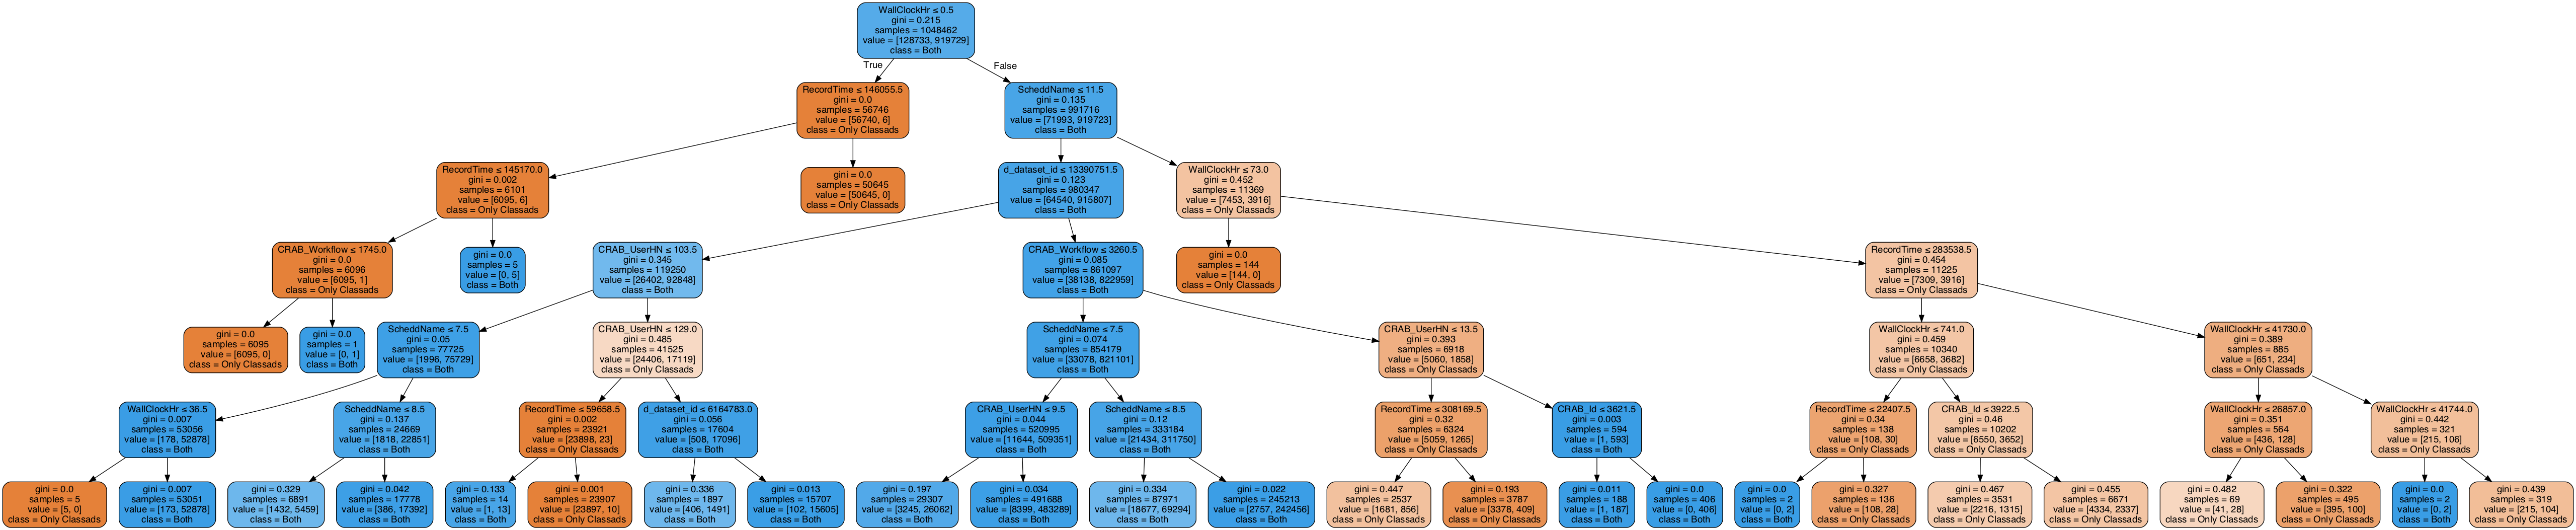

In [62]:

dot_data = StringIO()  

export_graphviz(
    model, 
    out_file = dot_data,  
    filled=True, rounded=True, proportion=False,
    special_characters=True, 
    feature_names=X.columns,
    class_names=["Only Classads", "Both"]
)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

In [65]:
#mean then standard deviation of record time and wallclockhr for isboth and not isboth
#standard deviation is pretty much always greater than mean so these  numbers arent great indicators

#print(np.mean(pd.to_numeric(goodads[goodads.isboth == 1].RecordTime))-np.mean(pd.to_numeric(goodads[goodads.isboth == 0].RecordTime)))
print(np.std(pd.to_numeric(goodads[goodads.isboth == 1].RecordTime)))
print(np.mean(pd.to_numeric(goodads[goodads.isboth == 0].RecordTime)))
print(np.std(pd.to_numeric(goodads[goodads.isboth == 0].RecordTime)))
print(np.mean(pd.to_numeric(goodads[goodads.isboth == 1].WallClockHr)))
print(np.std(pd.to_numeric(goodads[goodads.isboth == 1].WallClockHr)))
print(np.mean(pd.to_numeric(goodads[goodads.isboth == 0].WallClockHr)))
print(np.std(pd.to_numeric(goodads[goodads.isboth == 0].WallClockHr)))

-38638124.603515625
103631091.62311648
1551699915227.9075
83609160.6937482
2.0489428208383247
3.542206395126627
1.1620494852826238
3.8307115016289544


# Stuff for predicting using the decision tree created above

In [84]:
newx1 = treetest[treetest.day == 1551484800.0][predictors]
newy1 = treetest[treetest.day == 1551484800.0][target]
y1_test = model.predict(newx1)

#shifted later so that fwjr appears far more later in time
newx5 = treetest[treetest.day == 1551484800.0][predictors]
newy5 = treetest[treetest.day == 1551484800.0][target]
y5_test = model.predict(newx5)

In [85]:
#True Negative     False Positive
#False Negative    True Positive
print(confusion_matrix(newy1,y1_test))

[[  5969   5520]
 [  1010 233965]]


In [86]:
print(len(newy1))
print(sum(newy1))
print(len(newy5))
print(sum(newy5))

246464
234975
246464
234975


In [87]:
print(confusion_matrix(newy1,y1_test))

[[  5969   5520]
 [  1010 233965]]


In [88]:
print(confusion_matrix(newy5,y5_test))#10

[[  5969   5520]
 [  1010 233965]]


# Can be used to optimize the Decision Tree based on its ability to predict stuff on different days.  This is not totally necessary for finding seperation rules

In [77]:
# defining predictors
X = midtest[predictors]

# definig the target variable and mapping it to 1 if in fwjr and 0 otherwise
y = midtest[target]

# instantiating the model
false_positive = []
false_negative = []
true_positive = []
true_negative = []
for i in range(1,30):
    tree = DecisionTreeClassifier(max_depth = i, min_samples_leaf=90) 
    model = tree.fit(X,y)
    newx5 = treetest[treetest.day == 1551744000.0][predictors]
    newy5 = treetest[treetest.day == 1551744000.0][target]
    y5_test = model.predict(newx5)
    false_positive.append(confusion_matrix(newy5,y5_test)[0,1])
    false_negative.append(confusion_matrix(newy5,y5_test)[1,0])
    true_positive.append(confusion_matrix(newy5,y5_test)[1,1])
    true_negative.append(confusion_matrix(newy5,y5_test)[0,0])

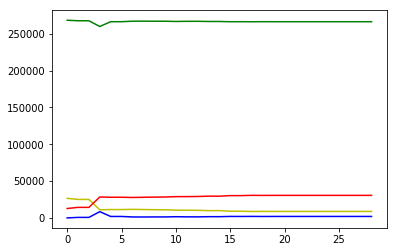

In [78]:
plt.plot(false_negative,'b')
plt.plot(false_positive,'y')
plt.plot(true_positive,'g')
plt.plot(true_negative,'r')
plt.show()

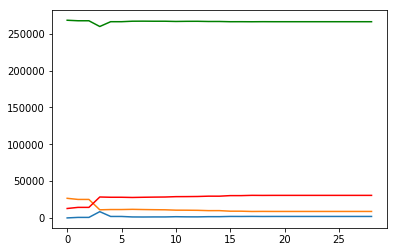

In [79]:
plt.plot(false_negative)
plt.plot(false_positive)
plt.plot(true_positive,'g')
plt.plot(true_negative,'r')
plt.show()

In [80]:
print(true_positive[45:55])
print(false_positive[45:55])
print(false_negative[45:55])

[]
[]
[]


In [81]:

print(true_positive[9])
print(true_negative[9])
print(false_positive[9])
print(false_negative[9])

266998
28376
11021
1335


In [82]:
print(true_positive[0:10])
print(false_positive[0:10])
print(false_negative[0:10])

[268333, 267632, 267632, 259832, 266359, 266359, 267013, 267087, 266988, 266998]
[26618, 25087, 25087, 11007, 11361, 11361, 11639, 11365, 11157, 11021]
[0, 701, 701, 8501, 1974, 1974, 1320, 1246, 1345, 1335]
